# Explainable Techniques II

Class: AIPI 590

Javidan Karimli

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1c08Ursi7TGIY18xKY93OWEIQzQ9zj50_?usp=drive_link)


In this notebook, we build a classification model on BMW sales volume using various features such as car type, mileage, and price. In this file, we built an XGBoost classifier to categorize the data into High and Low groups. In the final section, we generate PDP, ICE, and ALE plots to illustrate how changes in different features influence the model’s predictions.

The dataset is available on Kaggle: https://www.kaggle.com/datasets/sidraaazam/bmw-global-sales-analysis

In [145]:
!pip install dalex

In [ ]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

## Plot
import dalex as dx
from sklearn.inspection import PartialDependenceDisplay



In [89]:
path = '/content/drive/MyDrive/Duke/XAI/Explainable_AI_2/BMW sales data (2010-2024) (1).csv'

In [90]:
df = pd.read_csv(path)

In [91]:
df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [155]:
df['Sales_Classification'].value_counts(normalize = True)

,proportion
Sales_Classification,
Low,0.69508
High,0.30492


In [92]:
df.shape

(50000, 11)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


In [94]:
df.describe()

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


## Correlation Analysis

In [95]:
corr = df.corr(numeric_only=True)
corr

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
Year,1.000000,-0.001944,0.008741,0.003547,0.001671
Engine_Size_L,-0.001944,1.000000,-0.004906,0.000146,-0.003942
Mileage_KM,0.008741,-0.004906,1.000000,-0.004238,0.001434
Price_USD,0.003547,0.000146,-0.004238,1.000000,0.000080
Sales_Volume,0.001671,-0.003942,0.001434,0.000080,1.000000


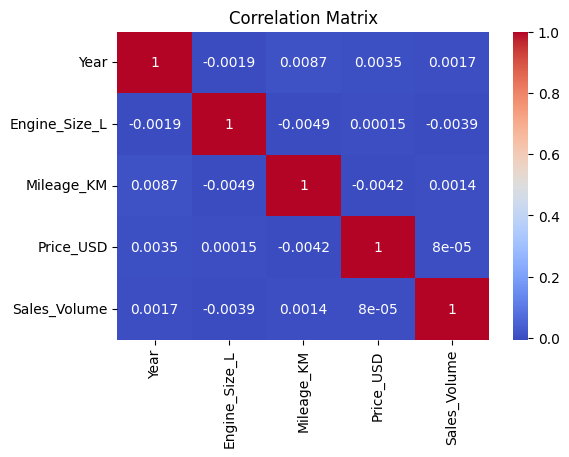

In [96]:
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Text(0.5, 1.0, 'Pair Plot for Correlation')

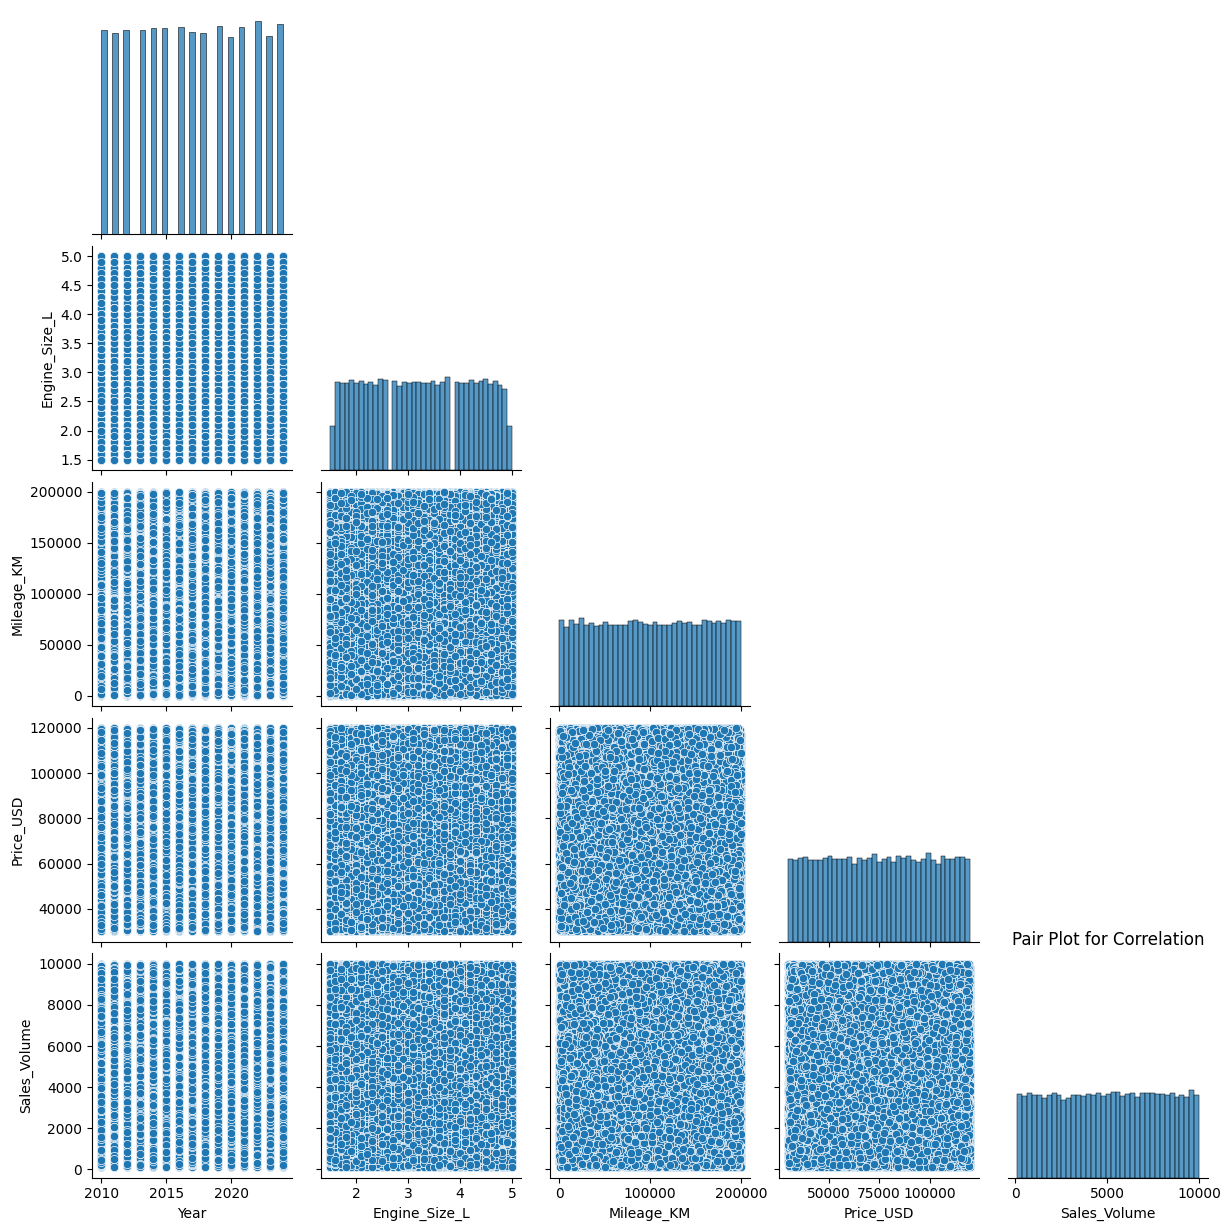

In [97]:
sns.pairplot(df, corner=True)
plt.title('Pair Plot for Correlation')

Based on the correlation matrix, there is almost no correlation between the numerical features, which is a positive sign.

## Dataset Correction

In [98]:
df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [99]:
model_df = df.copy()

scale_cols = ["Mileage_KM", "Price_USD"]
cat_cols = ['Model', 'Region', 'Color', "Fuel_Type", 'Transmission']
cols_to_drop = ['Sales_Volume']
target_col = 'Sales_Classification'



In [100]:
model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

In [101]:
scaler = StandardScaler()
model_df[scale_cols] = scaler.fit_transform(model_df[scale_cols])


In [102]:
model_df.drop(columns = cols_to_drop, inplace = True)
model_df[target_col] = model_df[target_col].replace({'High': 1, 'Low': 0})

/tmp/ipython-input-2746591498.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_df[target_col] = model_df[target_col].replace({'High': 1, 'Low': 0})


In [104]:
X  = model_df.drop(columns = target_col)
y = model_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [105]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (40000, 28) (40000,)
Test shape: (10000, 28) (10000,)


A few transformations were applied to prepare the dataset for modeling. One-hot encoding was used for the categorical columns, while the mileage and price columns were standardized using a scaler. The Sales Volumne column was dropped. Finally, the dataset was split into 80% training and 20% testing for modeling purposes.

## Model Creation

In [151]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb = XGBClassifier(random_state=42 ,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[00:07:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [152]:
y_pred = xgb.predict(X_test)

In [153]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

print("Precision:", round(precision_score(y_test, y_pred, average="weighted"), 4))
print("Recall:", round(recall_score(y_test, y_pred, average="weighted"), 4))
print("F1 Score:", round(f1_score(y_test, y_pred, average="weighted"), 4))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5268
Precision: 0.5693
Recall: 0.5268
F1 Score: 0.5426

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.58      0.63      6968
           1       0.29      0.40      0.34      3032

    accuracy                           0.53     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.57      0.53      0.54     10000



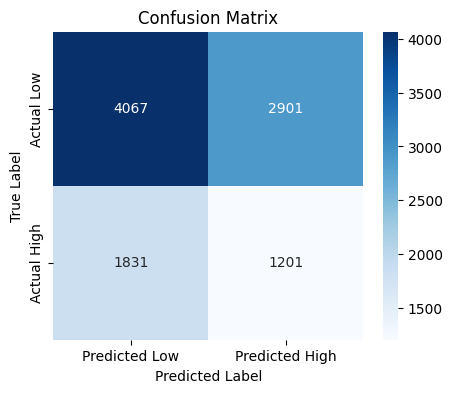

In [154]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=["Actual Low", "Actual High"],
                     columns=["Predicted Low", "Predicted High"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

The confusion matrix and model metrics clearly show that the model performs significantly worse when predicting the High sales classification. This may be due to class imbalance, suggesting that more targeted hyperparameter tuning strategies are needed to achieve better performance.

## Plotting  PDP, ICE, and ALE plots

<Figure size 1000x400 with 0 Axes>

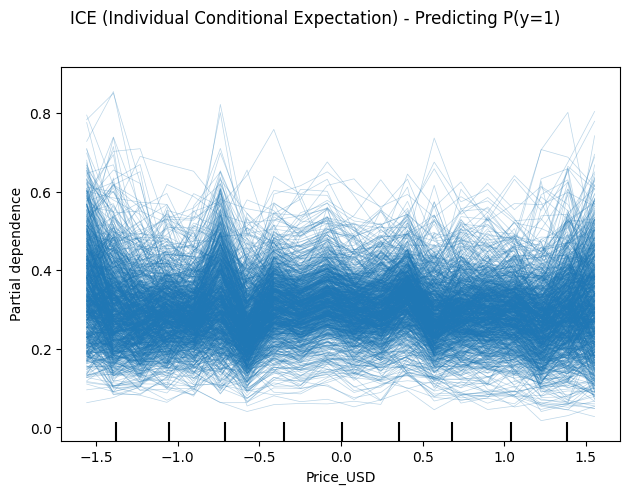

In [146]:
features = ["Price_USD"]
target_class = 1

fig = plt.figure(figsize=(10, 4 * len(features)))
PartialDependenceDisplay.from_estimator(
    estimator=xgb,
    X=X_test,
    features=features,
    kind="individual",
    response_method="predict_proba",
    target=target_class,
    grid_resolution=20
)
plt.suptitle("ICE (Individual Conditional Expectation) - Predicting P(y=1)", y=1.02)
plt.tight_layout()
plt.show()

The ICE plot of Price shows how the predicted probability of high sales changes for individual cars as the price varies. Each blue line represents one observation in the dataset. It stand out that the lines fluctuate quite a bit, meaning the model does not have a consistent pattern across different cars. Some predictions go up with higher prices, while others go down. This tells us the model is capturing complex and inconsistent relationships between price and the target, possibly because of noise in the data or interactions with other features.

<Figure size 1000x400 with 0 Axes>

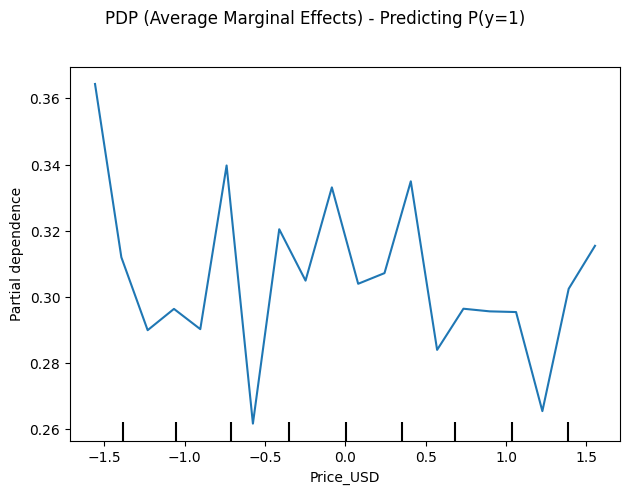

In [125]:
features = ["Price_USD"]
target_class = 1

fig = plt.figure(figsize=(10, 4 * len(features)))
PartialDependenceDisplay.from_estimator(
    estimator=xgb,
    X=X_test,
    features=features,
    kind="average",
    response_method="predict_proba",
    target=target_class,
    grid_resolution=20
)
plt.suptitle("PDP (Average Marginal Effects) - Predicting P(y=1)", y=1.02)
plt.tight_layout()
plt.show()

The PDP is the average of all those ICE lines. Here, the curve is fairly flat, with predicted probabilities hovering between 0.28 and 0.36 across the entire price range. This indicates that, on average, the model does not find price to be a strong driver of whether a car is classified into high or low sales. While individual cases may vary (as we saw in the ICE plot above), the overall marginal effect of price is weak.

In [149]:
features = ["Price_USD"]

def predict_pos_proba(model, X):
    proba = model.predict_proba(X)
    return proba[:, 1]

y_dummy = np.zeros(len(X_test))

exp = dx.Explainer(
    model=xgb,
    data=X_test,
    y=y_dummy,
    predict_function=predict_pos_proba,
    verbose=False
)

for f in features:
    ve = exp.model_profile(variables=[f], type="ale")
    print(f'\n\nPrinting ALE plot ({f}) - Predicting P(y=1)')

    ve.plot()


Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]



Printing ALE plot - Predicting P(y=1)


The ALE plot again shows the effect of price on predictions, but unlike PDP, it accounts for correlations between features. Here, the line also appears flat with small ups and downs, which reinforces the idea that price alone does not strongly influence the classification outcome. The little bumps in the line suggest some local effects, but they are minor. Overall, ALE confirms that the relationship between price and sales classification is limited and inconsistent.

## Conclusion

In this notebook, we first carried out an exploratory data analysis (EDA) to better understand the dataset and examined the correlation matrix of the features. The analysis showed that there are no strongly correlated columns, and the data appears fairly random without obvious patterns.

Next, we performed some feature engineering to prepare the dataset and trained a classification model using the XGBoost Classifier. The model struggled particularly with the minority class due to class imbalance. Even after adjusting for imbalance, the performance remained weak, suggesting that the dataset may lack strong predictive features. This indicates that further work is needed, such as introducing additional features or applying more advanced hyperparameter tuning methods to improve performance.

We then explored the effect of the scaled Price_USD feature using ICE, PDP, and ALE plots. The results showed high variability and no clear, consistent trend in the model’s predictions as price changes. The small bumps observed in the plots likely reflect local variations unrelated to price itself.

In summary, both the model’s performance and the interpretation plots suggest that the current features do not provide enough information for reliable classification. However, the ICE, PDP, and ALE visualizations confirm this conclusion by showing how both individual and average changes in price fail to drive meaningful model behavior.

### Generative AI use
The GPT-5 model was used to generate code snippets and to polish the explanatory text included in the markdown cells.